# Titanic Dataset

* The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

* Attribute Descriptions:
    * **PassengerId**: a unique identifier for each passenger
    * **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
    * **Pclass**: passenger class.
    * **Name**, **Sex**, **Age**: self-explanatory
    * **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
    * **Parch**: how many children & parents of the passenger aboard the Titanic.
    * **Ticket**: ticket id
    * **Fare**: price paid (in pounds)
    * **Cabin**: passenger's cabin number
    * **Embarked**: where the passenger embarked the Titanic

In [101]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns

import helper_funcs as hf

### Get the Data:

In [2]:
train_data = pd.read_csv('https://raw.githubusercontent.com/Spin8Cycle/data/main/data_samples/titanic/train.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/Spin8Cycle/data/main/data_samples/titanic/test.csv')

### Explore the Data:

In [93]:
hf.custom_info(train_data)

,Data Type,Non-Null Count,Null Count,% Missing,Distinct Values
PassengerId,int64,891,0,0.0,891
Survived,int64,891,0,0.0,2
Pclass,int64,891,0,0.0,3
Name,object,891,0,0.0,891
Sex,object,891,0,0.0,2
Age,float64,714,177,19.87,88
SibSp,int64,891,0,0.0,7
Parch,int64,891,0,0.0,7
Ticket,object,891,0,0.0,681
Fare,float64,891,0,0.0,248


In [97]:
# Numerical Data
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [100]:
# Categorical Data?
train_data.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [214]:
def category_distribution(df, args):
    data = []
    index_1 = []
    index_2 = []
    for n in args:
        vc = df[n].value_counts()
        vc2 = df[n].value_counts(normalize=True)
        for i in vc.index:
            index_1.append(n)
            index_2.append(i)
            data.append([vc[i], round(vc2[i]*100, 2)])

    #"""
    dist_df = pd.DataFrame(
        data, 
        index= [index_1, index_2],
        columns=['Counts', 'Distribution, %']
    )
    #"""
   

    return dist_df

x = category_distribution(train_data, ['Sex', 'Survived', 'Embarked'])
x

Counts  Distribution, %
Sex      male       577            64.76
         female     314            35.24
Survived 0          549            61.62
         1          342            38.38
Embarked S          644            72.44
         C          168            18.90
         Q           77             8.66

In [189]:
for i in train_data['Sex'].value_counts().index:
    print((i, train_data['Sex'].value_counts()[i]))


('male', 577)
('female', 314)


<Axes: xlabel='Sex', ylabel='count'>

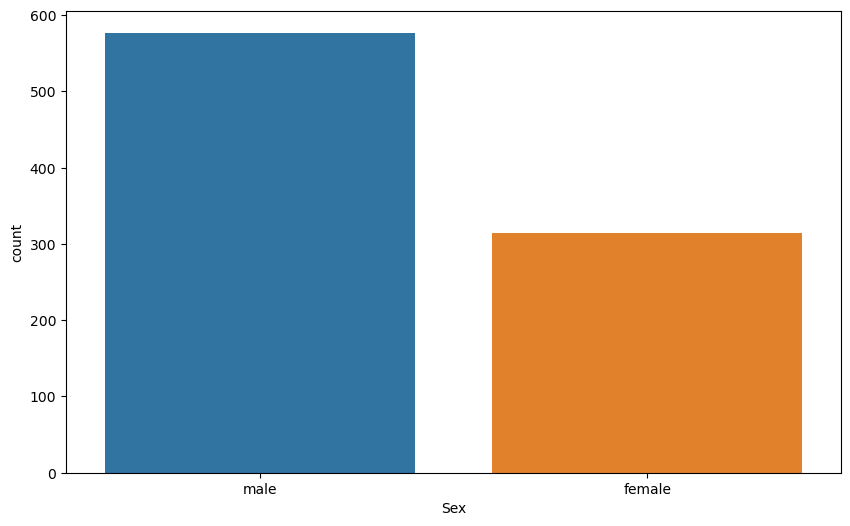

In [126]:
plt.figure(figsize=(10, 6))

sns.countplot(data=train_data, x='Sex')